In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
# 使用余弦相似度
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt

In [2]:
# 读取文章的具体内容数据 为articles_df，articles_df的每条记录均有对应的contentId
articles_df = pd.read_csv('shared_articles.csv')
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']  #我们仅考虑被分享过的文章
articles_df.head(3)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en


In [3]:
# 每条记录由 contentId与personId 的组合来对应
interactions_df = pd.read_csv('users_interactions.csv')
interactions_df.head(3)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN


In [4]:
event_type_strength = {
    'VIEW': 1.0,
    'LIKE': 2.0,
    'BOOKMARK': 2.5,
    'FOLLOW': 3.0,
    'COMMENT CREATED': 4.0,
}

# 评论的分数最高，其次是关注，然后是保存地址于书签。

# 基于评分标准，量化用户的互动行为数据
interactions_df['eventStrength'] = interactions_df['eventType'].apply(
    lambda x: event_type_strength[x])

In [5]:
interactions_df.head(3)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry,eventStrength
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,1.0
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,1.0
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,1.0


In [6]:
interactions_df.groupby(['personId', 'contentId']).size().groupby('personId').size()

personId
-9223121837663643404    43
-9212075797126931087     5
-9207251133131336884     7
-9199575329909162940    11
-9196668942822132778     7
                        ..
 9165571805999894845     5
 9187866633451383747    17
 9191849144618614467    12
 9199170757466086545    14
 9210530975708218054    63
Length: 1895, dtype: int64

In [7]:
len(interactions_df.loc[interactions_df['personId']==-9212075797126931087, 'contentId'].unique())

5

In [8]:
len(interactions_df.loc[interactions_df['personId']==-9223121837663643404, 'contentId'].unique())

43

In [9]:
users_interactions_count_df = interactions_df.groupby(
    ['personId', 'contentId']).size().groupby('personId').size()
print('# users: %d' % len(users_interactions_count_df))

# users: 1895


In [10]:
# 计算每个用户互动过的文章数量，然后再限制数量>=5，把互动文章数超过5的用户筛选出来。
users_with_enough_interactions_df = users_interactions_count_df[
    users_interactions_count_df >= 5].reset_index()[['personId']]
print('# users with at least 5 interactions: %d' %
      len(users_with_enough_interactions_df))

# users with at least 5 interactions: 1140


In [11]:
users_with_enough_interactions_df.head()

,personId
0,-9223121837663643404
1,-9212075797126931087
2,-9207251133131336884
3,-9199575329909162940
4,-9196668942822132778


In [12]:
# [['personId']]和['personId']的区别
users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[[
    'personId'
]]

,personId
0,-9223121837663643404
1,-9212075797126931087
2,-9207251133131336884
3,-9199575329909162940
4,-9196668942822132778
...,...
1135,9165571805999894845
1136,9187866633451383747
1137,9191849144618614467
1138,9199170757466086545


In [13]:
# 一个是Series一个是Dataframe
print(
    type(users_interactions_count_df[
        users_interactions_count_df >= 5].reset_index()['personId']))
print(
    type(users_interactions_count_df[
        users_interactions_count_df >= 5].reset_index()[['personId']]))

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


In [14]:
interactions_from_selected_users_df = interactions_df.merge(
    users_with_enough_interactions_df, how='inner', on='personId')
len(interactions_from_selected_users_df)

69868

In [15]:
interactions_from_selected_users_df.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry,eventStrength
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,1.0
1,1465413046,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5...,SP,BR,1.0
2,1464190235,VIEW,6437568358552101410,-8845298781299428018,-1157447994463607871,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,SP,BR,1.0
3,1459429221,VIEW,-4760639635023250284,-8845298781299428018,-5149610736659242149,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,SP,BR,1.0
4,1459274156,VIEW,-6142462826726347616,-8845298781299428018,-6283148774987755959,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,SP,BR,1.0


In [16]:
def smooth_user_preference(x):
    return math.log(1 + x, 2)

interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head(10)

# of unique user/item interactions: 39106


,personId,contentId,eventStrength
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925
5,-9223121837663643404,-7331393944609614247,1.000000
6,-9223121837663643404,-6872546942144599345,1.000000
7,-9223121837663643404,-6728844082024523434,1.000000
8,-9223121837663643404,-6590819806697898649,1.000000
9,-9223121837663643404,-6558712014192834002,1.584963


In [17]:
interactions_train_df, interactions_test_df = train_test_split(
    interactions_full_df,
    stratify=interactions_full_df['personId'],
    test_size=0.20,
    random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 31284
# interactions on Test set: 7822


In [18]:
# 使用personId（用户id）作为用户-物品评分数据集的索引，提高之后获取数据的速度
interactions_full_indexed_df = interactions_full_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')

In [19]:
interactions_full_indexed_df.head()

,contentId,eventStrength
personId,,
-9223121837663643404,-8949113594875411859,1.000000
-9223121837663643404,-8377626164558006982,1.000000
-9223121837663643404,-8208801367848627943,1.000000
-9223121837663643404,-8187220755213888616,1.000000
-9223121837663643404,-7423191370472335463,3.169925


In [20]:
# 获取用户的交互数据
def get_items_interacted(person_id, interactions_df):
    # 获取用户的数据
    interacted_items = interactions_df.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) ==
               pd.Series else [interacted_items])

In [21]:
set(['a','b','c'])-set(['a'])

{'b', 'c'}

**Top-N推荐的准确性评测方法**

In [22]:
# Top-N推荐的准确性
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100


# 模型评估
class ModelEvaluator:
    # 用于随机取出 sample_size篇、先前该用户没有互动过的文章
    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id,
                                                interactions_full_indexed_df)
        all_items = set(articles_df['contentId'])
        non_interacted_items = all_items - interacted_items  # set可以相减

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items,
                                                    sample_size)
        return set(non_interacted_items_sample)

    # 推荐列表中的文章是否有过互动行为
    def _verify_hit_top_n(self, item_id, recommended_items, topn):
        try:
            index = next(i for i, c in enumerate(recommended_items)
                         if c == item_id)
        except:
            index = -1
        hit = int(index in range(0, topn))
        return hit, index

    # 对用户进行模型评估
    def evaluate_model_for_user(self, model, person_id):
        # 提取测试集中用户实际有过互动行为的文章，
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(
                interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set(
                [int(interacted_values_testset['contentId'])])
        interacted_items_count_testset = len(
            person_interacted_items_testset)  # 测试集中用户实际互动过的文章

        # 算法推荐给某用户的文章列表
        person_recs_df = model.recommend_items(
            person_id,
            items_to_ignore=get_items_interacted(
                person_id, interactions_train_indexed_df),
            topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0

        # 遍历测试集中、用户实际互动过的文章
        for item_id in person_interacted_items_testset:
            # 随机提取100篇用户未看过的文章
            non_interacted_items_sample = self.get_not_interacted_items_sample(
                person_id,
                sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS,
                seed=item_id % (2**32))

            # 将测试集中实际有过互动的文章与100篇没有互动的文章混合
            # set.union：合并集合
            items_to_filter_recs = non_interacted_items_sample.union(
                set([item_id]))

            # 从推荐结果中过滤出用户实际互动过的这篇文章 或 100篇没有互动的文章，valid_recs_df长度为101（1+100）
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(
                items_to_filter_recs)]
            valid_recs = valid_recs_df['contentId'].values
            # 确认用户实际互动过的文章是否在Top-N推荐中，即101中的前5位或前10位
            hit_at_5, index_at_5 = self._verify_hit_top_n(
                item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(
                item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        # 召回率：测试集中、用户实际互动过的文章数与100篇未互动过的文章的混合中，
        # 实际互动过的文章在Top-5推荐列表的比例
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {
            'hits@5_count': hits_at_5_count,
            'hits@10_count': hits_at_10_count,
            'interacted_count': interacted_items_count_testset,
            'recall@5': recall_at_5,
            'recall@10': recall_at_10
        }
        return person_metrics
    # 模型评估
    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(
                list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        # people_metrics是个列表，由每个用户的召回率与实际互动文章数等信息构成，
        # detailed_results_df是people_metrics转化来的dataframe，
        # 包含所有用户的召回率与实际互动文章数等信息
        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)

        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(
            detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum(
        ) / float(detailed_results_df['interacted_count'].sum())
        # global_metrics包含的是基于整体用户的召回率
        global_metrics = {
            'modelName': model.get_model_name(),
            'recall@5': global_recall_at_5,
            'recall@10': global_recall_at_10
        }
        return global_metrics, detailed_results_df


model_evaluator = ModelEvaluator()

In [23]:
# 基于用户-文章评分表，以文章id分组，计算每篇文章的评分总和；并进行从高到低的排序
item_popularity_df = interactions_full_df.groupby(
    'contentId')['eventStrength'].sum().sort_values(
        ascending=False).reset_index()
item_popularity_df.head(10)

,contentId,eventStrength
0,-4029704725707465084,307.733799
1,-6783772548752091658,233.762157
2,-133139342397538859,228.024567
3,-8208801367848627943,197.107608
4,-6843047699859121724,193.825208
5,8224860111193157980,189.044680
6,-2358756719610361882,183.110951
7,2581138407738454418,180.282876
8,7507067965574797372,179.094002
9,1469580151036142903,170.548969


In [24]:
# 输入的popularity_df即为上面的item_popularity_df，第一列为文章id，第二列为文章评分
# 基于流行度的推荐方法，针对对象主要就是文章，因此量化指标是各篇文章eventStrength加和，互动人数与互动行为均会影响这个加和数
# 输入的items_df即为articles_df，有文章id，文章名称等文章的具体信息
class PopularityRecommender:
    MODEL_NAME = 'Popularity'

    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df

    def get_model_name(self):
        return self.MODEL_NAME

    def recommend_items(self,
                        user_id,
                        items_to_ignore=[],
                        topn=10,
                        verbose=False):
        # 推荐用户没看过的、但流行程度（评分总和高）的文章，取topn
        recommendations_df = self.popularity_df[
            ~self.popularity_df['contentId'].
            isin(items_to_ignore)].sort_values('eventStrength',
                                               ascending=False).head(topn)
        # 详细信息
        if verbose:
            if self.items_df is None:
                # 详细信息需要具体文章信息
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(
                self.items_df,
                how='left',
                left_on='contentId',
                right_on='contentId')[[
                    'eventStrength', 'contentId', 'title', 'url', 'lang'
                ]]

        return recommendations_df


popularity_model = PopularityRecommender(item_popularity_df, articles_df)

In [25]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)

print('\nGlobal metrics:\n%s' % pop_global_metrics)

pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...
1139 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.2418818716440808, 'recall@10': 0.3725389925850166}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,28,50,192,0.145833,0.260417,3609194402293569455
17,12,25,134,0.089552,0.186567,-2626634673110551643
16,13,23,130,0.100000,0.176923,-1032019229384696495
10,5,9,117,0.042735,0.076923,-1443636648652872475
82,26,40,88,0.295455,0.454545,-2979881261169775358
161,12,18,80,0.150000,0.225000,-3596626804281480007
65,20,34,73,0.273973,0.465753,1116121227607581999
81,17,23,69,0.246377,0.333333,692689608292948411
106,14,18,69,0.202899,0.260870,-9016528795238256703
52,21,28,68,0.308824,0.411765,3636910968448833585


In [26]:
#stopword.words指定停用词，即没有语义的词，后续可以直接过滤
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

# TfidfVectorizer实例化
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),   # ngram_range(min,max)是指将text分成min，min+1，min+2,.........max 个不同的词组
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)


item_ids = articles_df['contentId'].tolist()

# TfidfVectorizer 将文章的题目与内容转化为 TF-IDF 的特征向量矩阵
tfidf_matrix = vectorizer.fit_transform(articles_df['title'] + "" + articles_df['text'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<3047x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 638928 stored elements in Compressed Sparse Row format>

In [27]:
# 获取商品描述
def get_item_profile(item_id):
    idx = item_ids.index(item_id)  # item_ids是先前设定好的contentId
    item_profile = tfidf_matrix[idx:idx + 1]
    return item_profile


# 获取商品描述列表
def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)  # 行顺序拼接
    return item_profiles


# 构建用户描述
def build_users_profile(person_id, interactions_indexed_df):
    # interactions_person_df取自原用户-文章评分表
    interactions_person_df = interactions_indexed_df.loc[person_id]
    #取该用户已经互动过的文章对应的tf-idf的特征向量
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    # 用户对商品的互动行为评分
    user_item_strengths = np.array(
        interactions_person_df['eventStrength']).reshape(-1, 1)
    # 对该用户已经互动过的文章对应的tf-idf的特征值进行加权平均，权重为评分值
    # multiply:对应位置元素相乘
    # 权重:权重*文章/文章总分
    user_item_strengths_weighted_avg = np.sum(
        user_item_profiles.multiply(user_item_strengths),
        axis=0) / np.sum(user_item_strengths)
    # 正则化
    user_profile_norm = sklearn.preprocessing.normalize(
        user_item_strengths_weighted_avg)
    return user_profile_norm


# 构建用户描述列表
def build_users_profiles():
    interactions_indexed_df = interactions_full_df[
        interactions_full_df['contentId'].isin(
            articles_df['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(
            person_id, interactions_indexed_df)
    return user_profiles

In [28]:
user_profiles = build_users_profiles()
len(user_profiles)

1140

In [29]:
user_profiles
# 字典，key为用户id，对应的value是该用户互动过的所有文章的tf-idf的特征向量值，二维矩阵

{-9223121837663643404: array([[0.00679228, 0.01231635, 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 -9212075797126931087: array([[0.        , 0.02568444, 0.        , ..., 0.        , 0.00905023,
         0.        ]]),
 -9207251133131336884: array([[0.0342535 , 0.00501752, 0.        , ..., 0.01868609, 0.0215861 ,
         0.        ]]),
 -9199575329909162940: array([[0.        , 0.0179398 , 0.        , ..., 0.        , 0.        ,
         0.01070192]]),
 -9196668942822132778: array([[0.        , 0.        , 0.        , ..., 0.01710639, 0.        ,
         0.01102536]]),
 -9188188261933657343: array([[0.02957743, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 -9172914609055320039: array([[0.03756122, 0.01628101, 0.        , ..., 0.015573  , 0.        ,
         0.        ]]),
 -9156344805277471150: array([[0.        , 0.03884458, 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 -9120685872592674274: array([[0.       

In [30]:
test_df=interactions_full_df[interactions_full_df['contentId'] \
                                               .isin(articles_df['contentId'])].set_index('personId')

interactions_person_df = test_df.loc[-1479311724257856983]               
# interactions_person_df取自原用户-文章评分表
user_item_profiles = get_item_profiles(interactions_person_df['contentId'])   
#取该用户已经互动过的文章对应的tf-idf的特征向量

user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
# 对该用户已经互动过的文章对应的tf-idf的特征值进行加权平均，权重为评分值

In [31]:
user_item_profiles.shape

(146, 5000)

In [32]:
user_item_strengths.shape

(146, 1)

In [33]:
user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
# user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)

In [34]:
myprofile = user_profiles[-1479311724257856983]
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles[-1479311724257856983].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 5000)


,token,relevance
0,learning,0.305655
1,machine learning,0.255557
2,machine,0.246095
3,google,0.208590
4,data,0.172509
5,ai,0.136818
6,algorithms,0.102396
7,graph,0.098438
8,like,0.096970
9,language,0.083993


In [35]:
myprofile

array([[0.00075966, 0.01578792, 0.00042694, ..., 0.00071554, 0.00387437,
        0.        ]])

In [36]:
class ContentBasedRecommender:

    MODEL_NAME = 'Content-Based'

    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df

    def get_model_name(self):
        return self.MODEL_NAME

    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        # 计算余弦相似度，所有文章的特征向量矩阵与该用户已互动文章对应的特征向量矩阵
        # 是为了之后找出与该用户已互动过文章对应的特征矩阵的cosine similarity高的文章
        cosine_similarities = cosine_similarity(user_profiles[person_id],
                                                tfidf_matrix)
        # 取 cosine similarity 中top N的文章（从高到低排序，余弦相似度越高、则这篇文章与该用户互动过那篇的相似度就越高）
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        similar_items = sorted([(item_ids[i], cosine_similarities[0, i])
                                for i in similar_indices],
                               key=lambda x: -x[1])
        return similar_items

    def recommend_items(self,
                        user_id,
                        items_to_ignore=[],
                        topn=10,
                        verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        # 过滤掉已经看过的文章
        similar_items_filtered = list(
            filter(lambda x: x[0] not in items_to_ignore, similar_items))

        recommendations_df = pd.DataFrame(similar_items_filtered,
                                          columns=['contentId',
                                                   'recStrength']).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(
                self.items_df,
                how='left',
                left_on='contentId',
                right_on='contentId')[[
                    'recStrength', 'contentId', 'title', 'url', 'lang'
                ]]

        return recommendations_df


content_based_recommender_model = ContentBasedRecommender(articles_df)

In [37]:
cosine_similarities2=cosine_similarity(user_profiles[-1479311724257856983], tfidf_matrix)
print(tfidf_matrix.todense().shape)
print(cosine_similarities2.shape)   # 最后形成的cosine_similarity是基于每篇文章的

(3047, 5000)
(1, 3047)


In [38]:
similar_indices2=cosine_similarities2.argsort().flatten()[-5:]  # flatten()去掉一层，得到的是相似度前5的indices
sorted([(item_ids[i], cosine_similarities2[0,i]) for i in similar_indices2], key=lambda x: -x[1])  #（ContentId, 相似度）

[(5250363310227021277, 0.6876796576799992),
 (-7126520323752764957, 0.685643863654037),
 (638282658987724754, 0.6275659687411577),
 (5258604889412591249, 0.5898246444145042),
 (-8068727428160395745, 0.580009720669323)]

--------------------

基于内容的推荐模型， **Recall@5** 为 **0.41**, 说明 测试集中、用户实际互动的文章中有 **41%** 是在Top5推荐的文章中的。

**Recall@10** 为 **0.52 (52%)**。

（基于物品流行度的推荐模型中**Recall@5** 为 0.2417，**Recall@10** 为 0.3747）

基于内容的推荐模型预测的效果较好，预测准确度高于基于物品流行度的推荐模型。

In [39]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)

print('\nGlobal metrics:\n%s' % cb_global_metrics)

cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
1139 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.41459984658655075, 'recall@10': 0.5241626182562005}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,16,26,192,0.083333,0.135417,3609194402293569455
17,21,35,134,0.156716,0.261194,-2626634673110551643
16,22,34,130,0.169231,0.261538,-1032019229384696495
10,34,54,117,0.290598,0.461538,-1443636648652872475
82,8,15,88,0.090909,0.170455,-2979881261169775358
161,14,23,80,0.175000,0.287500,-3596626804281480007
65,10,15,73,0.136986,0.205479,1116121227607581999
81,11,20,69,0.159420,0.289855,692689608292948411
106,5,10,69,0.072464,0.144928,-9016528795238256703
52,4,11,68,0.058824,0.161765,3636910968448833585


In [40]:
# 构建数据透视表，行为user_id，列为contentId，数值为评分
users_items_pivot_matrix_df = interactions_train_df.pivot(index='personId', 
                                                          columns='contentId', 
                                                          values='eventStrength').fillna(0)

users_items_pivot_matrix_df.head(10)

contentId,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9176143510534135851,-9172673334835262304,-9171475473795142532,-9166778629773133902,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9188188261933657343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9172914609055320039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9156344805277471150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9120685872592674274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
# users_items_pivot_matrix = users_items_pivot_matrix_df.as_matrix()
users_items_pivot_matrix = users_items_pivot_matrix_df.values

users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[-9223121837663643404,
 -9212075797126931087,
 -9207251133131336884,
 -9199575329909162940,
 -9196668942822132778,
 -9188188261933657343,
 -9172914609055320039,
 -9156344805277471150,
 -9120685872592674274,
 -9109785559521267180]

In [46]:
from scipy.sparse.linalg import svds
# 人为设定的 k值
NUMBER_OF_FACTORS_MF = 15

# 基于原始的用户-物品矩阵进行矩阵分解，使用scipy.sparse.linalg.svds即能完成操作，得到3个矩阵，注意这边的Vt已经是转置之后的矩阵了
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [47]:
U.shape

(1140, 15)

In [48]:
Vt.shape

(15, 2926)

In [49]:
# 注意sigma除了对角元素不为0，其他元素都为0。所以返回的时候，作为一维矩阵返回，需要重新转成对角矩阵
sigma.shape

(15,)

In [50]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [51]:
sigma

array([[26.35998   ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , 26.96029367,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , 27.73377221,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , 28.51766202,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , 29.54224668,
         0.        ,  0.        ,  0.        , 

In [52]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 0.01039915,  0.00081872, -0.01725263, ...,  0.00140708,
         0.0110647 ,  0.00226063],
       [-0.00019285, -0.00031318, -0.00264624, ...,  0.00251658,
         0.00017609, -0.00189488],
       [-0.01254721,  0.0065947 , -0.00590676, ...,  0.00698975,
        -0.01015696,  0.01154572],
       ...,
       [-0.02995379,  0.00805715, -0.01846307, ..., -0.01083078,
        -0.00118591,  0.0096798 ],
       [-0.01845505,  0.00467019,  0.01219602, ...,  0.00409507,
         0.00019482, -0.00752562],
       [-0.01506374,  0.00327732,  0.13391269, ..., -0.01191815,
         0.06422074,  0.01303244]])

In [53]:
all_user_predicted_ratings.shape

(1140, 2926)

In [54]:
test=np.matmul(np.matmul(U, sigma), Vt)
np.array_equal(test, all_user_predicted_ratings) # 判断两个array是否相同的方法

True

In [55]:
# 将新矩阵转化为 dataframe，并转置，将contentId变为行索引，即每一行是一篇文章对应的记录
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,...,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.010399,-0.000193,-0.012547,0.052958,-0.010035,-0.005412,-0.003918,0.049302,-0.013458,-0.020052,...,-0.005306,-0.089463,-0.000048,0.015023,0.020953,-0.009394,-0.019114,-0.029954,-0.018455,-0.015064
-9216926795620865886,0.000819,-0.000313,0.006595,-0.000649,0.000151,0.000338,0.000197,0.000861,0.002341,0.001765,...,0.000095,0.013915,0.000506,0.001460,0.014863,0.000940,0.002391,0.008057,0.004670,0.003277
-9194572880052200111,-0.017253,-0.002646,-0.005907,-0.003666,0.021300,-0.001278,0.029100,-0.014730,-0.023410,0.004950,...,0.011529,0.046012,0.010485,0.018768,0.150362,0.019052,0.023870,-0.018463,0.012196,0.133913
-9192549002213406534,0.035081,0.000391,-0.029046,-0.007702,0.017615,0.005496,0.013435,0.057563,0.047532,0.004209,...,0.020149,0.260317,0.007923,-0.008079,0.034164,0.011558,0.013793,-0.010138,0.025703,0.095753
-9190737901804729417,0.019939,-0.004799,0.006684,0.006363,-0.001997,0.002356,0.003876,0.004118,-0.027098,0.019793,...,0.003719,0.004478,0.001917,0.000341,-0.034535,-0.001160,0.001307,0.002957,0.005991,-0.015662
-9189659052158407108,0.008661,0.006604,0.001463,-0.002918,0.008551,-0.001637,0.005443,0.002193,0.023148,0.021311,...,0.024496,0.090091,-0.002703,0.001883,0.098925,0.008484,0.014513,0.016385,0.021794,0.068420
-9176143510534135851,0.046426,0.006374,0.013802,0.010265,-0.002538,-0.004453,0.016615,0.023070,0.059582,0.057307,...,0.003667,0.073024,-0.015438,0.001199,-0.005606,-0.000307,0.005250,0.041064,0.030733,0.037113
-9172673334835262304,0.005083,0.000618,0.002845,-0.001103,0.000398,0.000754,0.001346,0.002713,-0.002811,0.003930,...,0.005625,0.019382,0.000544,-0.000992,-0.008110,0.000156,0.003408,0.003614,0.007607,-0.003650
-9171475473795142532,0.024453,-0.000761,0.000963,-0.002817,0.002466,0.001215,0.009339,-0.003530,-0.007137,0.023221,...,0.009667,0.017163,0.000424,0.000060,-0.016698,0.002045,0.007644,0.000955,0.011074,-0.006657


In [56]:
len(cf_preds_df.columns)

1140

In [57]:
class CFRecommender:

    MODEL_NAME = 'Collaborative Filtering'

    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        # 分别初始化预测评分矩阵 与 文章内容矩阵

    def get_model_name(self):
        return self.MODEL_NAME

    def recommend_items(self,
                        user_id,
                        items_to_ignore=[],
                        topn=10,
                        verbose=False):
        # 根据user_id获取该用户对所有文章的预测评分，并从高到低进行排序
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(
            ascending=False).reset_index().rename(
                columns={user_id: 'recStrength'})

        # 推荐给该用户他没看过（没互动过）、但评分最高的文章
        recommendations_df = sorted_user_predictions[
            ~sorted_user_predictions['contentId'].
            isin(items_to_ignore)].sort_values('recStrength',
                                               ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(
                self.items_df,
                how='left',
                left_on='contentId',
                right_on='contentId')[[
                    'recStrength', 'contentId', 'title', 'url', 'lang'
                ]]

        return recommendations_df


cf_recommender_model = CFRecommender(cf_preds_df,
                                     articles_df)  #放入预测评分矩阵 与 文章内容矩阵

In [58]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(
    cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
1139 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.33392994119151115, 'recall@10': 0.46803886474047557}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,21,46,192,0.109375,0.239583,3609194402293569455
17,30,56,134,0.223881,0.417910,-2626634673110551643
16,16,34,130,0.123077,0.261538,-1032019229384696495
10,38,51,117,0.324786,0.435897,-1443636648652872475
82,39,48,88,0.443182,0.545455,-2979881261169775358
161,22,34,80,0.275000,0.425000,-3596626804281480007
65,24,32,73,0.328767,0.438356,1116121227607581999
81,16,21,69,0.231884,0.304348,692689608292948411
106,20,28,69,0.289855,0.405797,-9016528795238256703
52,23,30,68,0.338235,0.441176,3636910968448833585


In [59]:
class HybridRecommender:

    MODEL_NAME = 'Hybrid'

    def __init__(self, cb_rec_model, cf_rec_model, items_df):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.items_df = items_df
        # 分别初始化基于内容的推荐模型、协同过滤推荐模型、文章内容矩阵

    def get_model_name(self):
        return self.MODEL_NAME

    def recommend_items(self,
                        user_id,
                        items_to_ignore=[],
                        topn=10,
                        verbose=False):
        # 基于内容的推荐算法，取其前1000 的推荐文章与互动分值
        cb_recs_df = self.cb_rec_model.recommend_items(
            user_id,
            items_to_ignore=items_to_ignore,
            verbose=verbose,
            topn=1000).rename(columns={'recStrength': 'recStrengthCB'})

        # 协同过滤算法，取其前1000 的推荐文章与互动分值
        cf_recs_df = self.cf_rec_model.recommend_items(
            user_id,
            items_to_ignore=items_to_ignore,
            verbose=verbose,
            topn=1000).rename(columns={'recStrength': 'recStrengthCF'})

        # 使用contentId将上面两个算法的推荐结果连接成大表，注意使用inner join，即只保留两种算法均有推荐的物品
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how='inner',
                                   left_on='contentId',
                                   right_on='contentId')

        # 混合型的推荐评分 = 协同过滤算法的推荐评分*基于内容的算法的推荐评分
        recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df[
            'recStrengthCF']

        # 将推荐结果按照混合型的推荐评分 从高到低排序
        recommendations_df = recs_df.sort_values('recStrengthHybrid',
                                                 ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(
                self.items_df,
                how='left',
                left_on='contentId',
                right_on='contentId')[[
                    'recStrengthHybrid', 'contentId', 'title', 'url', 'lang'
                ]]

        return recommendations_df


hybrid_recommender_model = HybridRecommender(content_based_recommender_model,
                                             cf_recommender_model, articles_df)

In [60]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(
    hybrid_recommender_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
1139 users processed

Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.43390437228330353, 'recall@10': 0.537969828688315}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,27,40,192,0.140625,0.208333,3609194402293569455
17,38,56,134,0.283582,0.417910,-2626634673110551643
16,27,35,130,0.207692,0.269231,-1032019229384696495
10,37,52,117,0.316239,0.444444,-1443636648652872475
82,26,31,88,0.295455,0.352273,-2979881261169775358
161,20,28,80,0.250000,0.350000,-3596626804281480007
65,16,21,73,0.219178,0.287671,1116121227607581999
81,14,23,69,0.202899,0.333333,692689608292948411
106,14,19,69,0.202899,0.275362,-9016528795238256703
52,16,19,68,0.235294,0.279412,3636910968448833585


**对比不同推荐算法在本案例中的准确率**

In [61]:
# 将四类模型的推荐评估召回率拼接到dataframe中
global_metrics_df = pd.DataFrame([pop_global_metrics, cf_global_metrics, cb_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@5,recall@10
modelName,,
Popularity,0.241882,0.372539
Collaborative Filtering,0.333930,0.468039
Content-Based,0.414600,0.524163
Hybrid,0.433904,0.537970


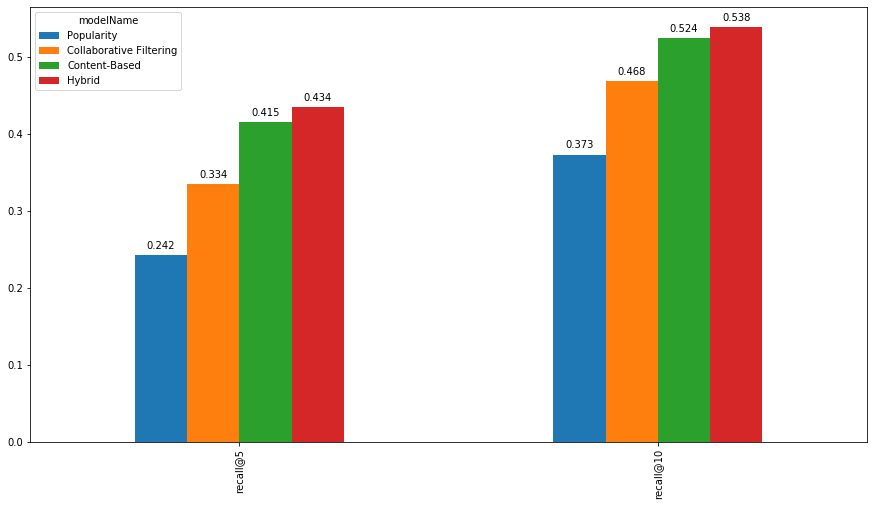

In [62]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(
    kind='bar', figsize=(15, 8))  #因为需要分的类其实是推荐模型的类型，所以transpose一下
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points')

**测试**

已知有一个用户，他对机器学习、人工智能等领域十分感兴趣，person_id为-1479311724257856983

In [63]:
def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions_df = interactions_test_indexed_df
    else:
        interactions_df = interactions_train_indexed_df
    return interactions_df.loc[person_id].merge(
        articles_df, how='left', left_on='contentId',
        right_on='contentId').sort_values('eventStrength', ascending=False)[[
            'eventStrength', 'contentId', 'title', 'url', 'lang'
        ]]

我们可以从训练集数据看到这个用户经常浏览的标题，主要都是和该用户感兴趣的机器学习、深度学习、算法等主题相关的（ **machine learning**, **deep learning**, **algorithm**）

In [64]:
inspect_interactions(-1479311724257856983, test_set=False).head(20)

,eventStrength,contentId,title,url,lang
115,4.285402,7342707578347442862,"At eBay, Machine Learning is Driving Innovativ...",https://www.ebayinc.com/stories/news/at-ebay-m...,en
38,4.129283,621816023396605502,AI Is Here to Help You Write Emails People Wil...,http://www.wired.com/2016/08/boomerang-using-a...,en
8,4.044394,-4460374799273064357,"Deep Learning for Chatbots, Part 1 - Introduction",http://www.wildml.com/2016/04/deep-learning-fo...,en
116,3.954196,-7959318068735027467,Auto-scaling scikit-learn with Spark,https://databricks.com/blog/2016/02/08/auto-sc...,en
10,3.906891,2589533162305407436,6 reasons why I like KeystoneML,http://radar.oreilly.com/2015/07/6-reasons-why...,en
28,3.700440,5258604889412591249,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en
6,3.700440,-398780385766545248,10 Stats About Artificial Intelligence That Wi...,http://www.fool.com/investing/2016/06/19/10-st...,en
113,3.643856,-6467708104873171151,5 reasons your employees aren't sharing their ...,http://justcuriousblog.com/2016/04/5-reasons-y...,en
42,3.523562,-4944551138301474550,Algorithms and architecture for job recommenda...,https://www.oreilly.com/ideas/algorithms-and-a...,en
43,3.459432,-8377626164558006982,Bad Writing Is Destroying Your Company's Produ...,https://hbr.org/2016/09/bad-writing-is-destroy...,en


**我们可以看到给这个用户的推荐也是和他的兴趣相关的，比如主题包含machine learning、AI、TensorFlow等等，所以的确和该用户的匹配度较高**

In [65]:
hybrid_recommender_model.recommend_items(-1479311724257856983, topn=20, verbose=True)

,recStrengthHybrid,contentId,title,url,lang
0,0.484696,3269302169678465882,The barbell effect of machine learning.,http://techcrunch.com/2016/06/02/the-barbell-e...,en
1,0.428711,5092635400707338872,Power to the People: How One Unknown Group of ...,https://medium.com/@atduskgreg/power-to-the-pe...,en
2,0.411263,5258604889412591249,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en
3,0.358686,-9033211547111606164,Google's Cloud Machine Learning service is now...,https://techcrunch.com/2016/09/29/googles-clou...,en
4,0.335053,5250363310227021277,"How Google is Remaking Itself as a ""Machine Le...",https://backchannel.com/how-google-is-remaking...,en
5,0.316371,-7126520323752764957,"How Google is Remaking Itself as a ""Machine Le...",https://backchannel.com/how-google-is-remaking...,en
6,0.316029,7395435905985567130,The AI business landscape,https://www.oreilly.com/ideas/the-ai-business-...,en
7,0.309052,-5756697018315640725,Being A Developer After 40 - Free Code Camp,https://medium.freecodecamp.com/being-a-develo...,en
8,0.295994,-8190931845319543363,Machine Learning Is At The Very Peak Of Its Hy...,https://arc.applause.com/2016/08/17/gartner-hy...,en
9,0.294210,1415230502586719648,Machine Learning Is Redefining The Enterprise ...,http://www.forbes.com/sites/louiscolumbus/2016...,en
